In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_io as tfio

import dataLoader
import modelo
import evaluador

In [2]:
metadata_path = "..\\metadata.csv"
audio_dir = "..\\dataset\\audios"

audio_dataset = dataLoader.AudioDataset(metadata_path, audio_dir)
train_ds, val_ds, test_ds = audio_dataset.preprocess_datasets()

dir_metadata = "..\\dataset\\sonidos_grabados\\mdgrabados.csv"
dir_audios =  "..\\dataset\\sonidos_grabados"

recorded_dataset = dataLoader.AudioDataset(dir_metadata, dir_audios, split=False)
test_ds2 = recorded_dataset.create_single_dataset()

In [2]:
import pickle
with open('entrenamiento\\historia_entrenamiento', 'rb') as file:
    historia = pickle.load(file)

modelo = tf.keras.models.load_model('modelo_propio')

### Evaluo en test set 1

In [4]:
eval = evaluador.ClassifierEvaluator(modelo)
loss, bacc, precision, recall, F1, TP, TN, FP, FN = eval.evaluate(test_ds)

62/62 [==============================] - 24s 365ms/step - loss: 0.0912 - Accuracy: 0.9705 - Precision: 0.9498 - Recall: 0.9359 - TP: 690.7100 - TN: 1193.6801 - FP: 32.3200 - FN: 47.2900
Loss: 0.09
Accuracy: 0.97
Precision: 0.97
Recall: 0.95
F1: 0.96
TP:  701.0
TN:  1205.0
FP:  21.0
FN:  37.0


c:\Users\user\Documents\Tesis\codigo\evaluador.py:44: RuntimeWarning: invalid value encountered in true_divide
  F1 = (2 * precision * recall) / (precision + recall)


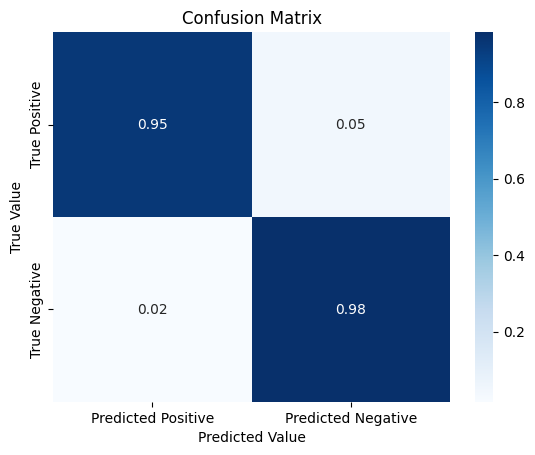

In [5]:
eval.plot_confusion_matrix(TP, TN, FP, FN)

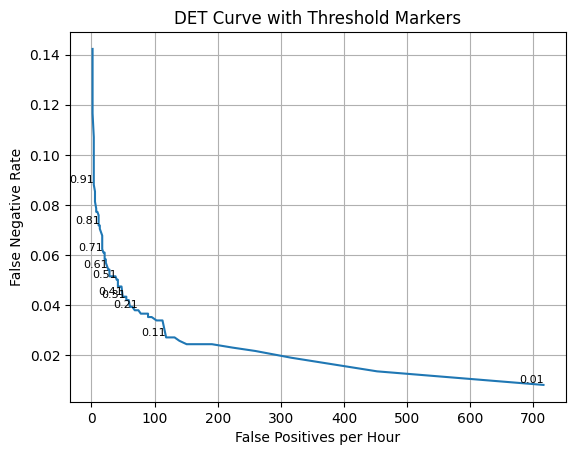

In [6]:
eval.curva_det(TP, TN, FP, FN)

In [11]:
dic = {'th':np.linspace(0.01, 1, 100, dtype=np.float64).round(2).tolist(),
       'TP':TP,
       'TN':TN,
       'FP':FP,
       'FN':FN}

import pandas as pd
df = pd.DataFrame(dic)
df.to_csv('det_curve.csv', index=False)

### Evaluo en test set 2

In [7]:
eval = evaluador.ClassifierEvaluator(modelo)
loss2, bacc2, precision2, recall2, F12, TP2, TN2, FP2, FN2 = eval.evaluate(test_ds2)

174/174 [==============================] - 71s 387ms/step - loss: 0.1451 - Accuracy: 0.9632 - Precision: 0.9386 - Recall: 0.8434 - TP: 984.2300 - TN: 4304.8101 - FP: 68.1900 - FN: 182.7700
Loss: 0.15
Accuracy: 0.96
Precision: 0.96
Recall: 0.86
F1: 0.91
TP:  1000.0
TN:  4336.0
FP:  37.0
FN:  167.0


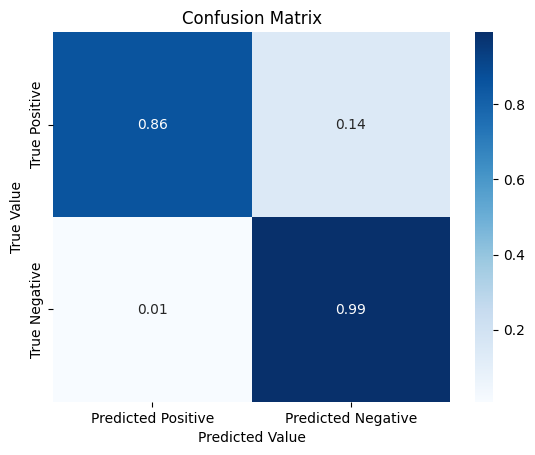

In [8]:
eval.plot_confusion_matrix(TP2, TN2, FP2, FN2)

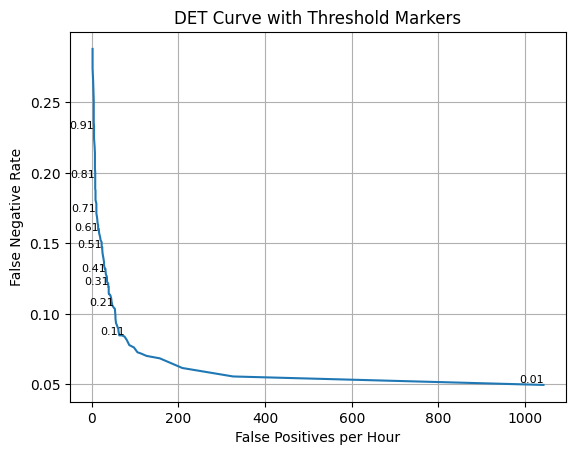

In [9]:
eval.curva_det(TP2, TN2, FP2, FN2)

### A ver en que audios falla?

In [16]:
modelo_final = tf.keras.models.load_model('modelo_final')

def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [33]:
for file in os.listdir(dir_audios):
    if file[-4:] != '.wav':
        continue
    filepath = os.path.join(dir_audios, file)
    wav = load_wav_16k_mono(filepath)
    res = modelo_final(wav)
    threshold = 0.9
    res_rounded = tf.where(res >= threshold, tf.ones_like(res), tf.zeros_like(res))

    total_elements = tf.size(res_rounded).numpy()
    num_ones = tf.reduce_sum(res_rounded)
    num_zeros = total_elements - num_ones

    percentage_ones = (num_ones / total_elements) * 100
    percentage_zeros = (num_zeros / total_elements) * 100

    print(f'File: {file}')
    print("Percentage of possitives:", percentage_ones.numpy())
    print("Percentage of negatives:", percentage_zeros.numpy())
    print('---------------------------------------')

File: STE-002.wav
Percentage of possitives: 97.66537
Percentage of negatives: 2.3346303
---------------------------------------
File: STE-004.wav
Percentage of possitives: 97.3607
Percentage of negatives: 2.6392963
---------------------------------------
File: STE-005.wav
Percentage of possitives: 56.590508
Percentage of negatives: 43.409492
---------------------------------------
File: STE-006.wav
Percentage of possitives: 0.9463723
Percentage of negatives: 99.05363
---------------------------------------
File: STE-007.wav
Percentage of possitives: 0.1552795
Percentage of negatives: 99.84472
---------------------------------------
File: STE-008.wav
Percentage of possitives: 0.03231018
Percentage of negatives: 99.96769
---------------------------------------


### Ploteo de curvas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sa = pd.read_excel('..\\resultados.xlsx', sheet_name='aumento', usecols='C:F', names=['TP', 'TN', 'FP', 'FN'])
all = pd.read_excel('..\\resultados.xlsx', sheet_name='aumento', usecols='H:K', names=['TP', 'TN', 'FP', 'FN'])
fm_tm = pd.read_excel('..\\resultados.xlsx', sheet_name='aumento', usecols='M:P', names=['TP', 'TN', 'FP', 'FN'])
ps_bn = pd.read_excel('..\\resultados.xlsx', sheet_name='aumento', usecols='R:U', names=['TP', 'TN', 'FP', 'FN'])
ps = pd.read_excel('..\\resultados.xlsx', sheet_name='aumento', usecols='X:AA', names=['TP', 'TN', 'FP', 'FN'])
tm = pd.read_excel('..\\resultados.xlsx', sheet_name='aumento', usecols='AD:AG', names=['TP', 'TN', 'FP', 'FN'])
bn = pd.read_excel('..\\resultados.xlsx', sheet_name='aumento', usecols='AJ:AM', names=['TP', 'TN', 'FP', 'FN'])
fm = pd.read_excel('..\\resultados.xlsx', sheet_name='aumento', usecols='AP:AS', names=['TP', 'TN', 'FP', 'FN'])
umbral = np.linspace(0.01, 1, 100, dtype=np.float64).round(2)


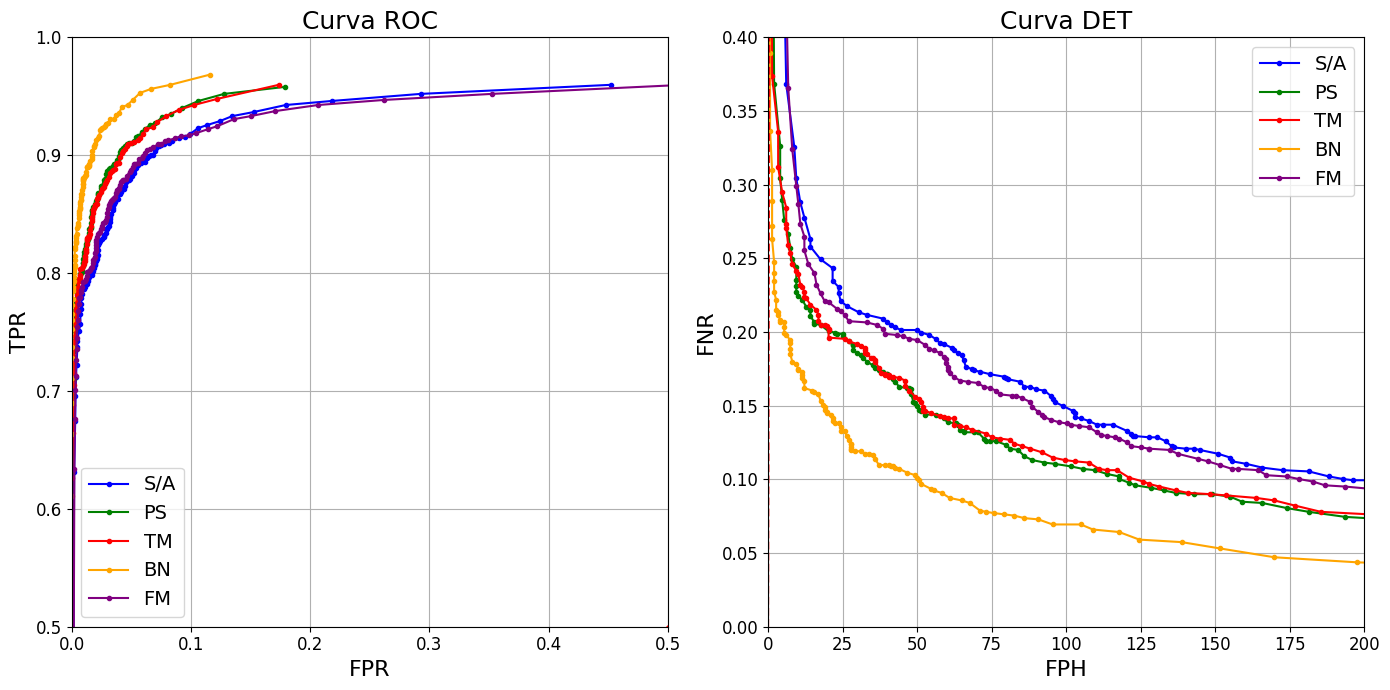

In [75]:
import pandas as pd
import matplotlib.pyplot as plt

# List of dataframes
dataframes = [sa, ps, tm, bn, fm]

# Calculate HORAS for each dataframe
HORAS_list = [(df.iloc[1, 0] + df.iloc[1, 1] + df.iloc[1, 2] + df.iloc[1, 3]) * 0.96 / 3600 for df in dataframes]

# Names for each dataframe for labeling the plots
labels = ['S/A', 'PS', 'TM', 'BN', 'FM']

# Create subplots
fig, axis = plt.subplots(1, 2, figsize=(14, 7))

# Colors for each dataframe
colors = ['b', 'g', 'r', 'orange', 'purple']

for df, HORAS, label, color in zip(dataframes, HORAS_list, labels, colors):
    df['TPR'] = df['TP'] / (df['TP'] + df['FN'])
    df['FPR'] = df['FP'] / (df['FP'] + df['TN'])
    df['FPH'] = df['FP'] / HORAS
    df['FNR'] = df['FN'] / (df['TP'] + df['FN'])
    
    # Plot the ROC curve
    axis[0].plot(df['FPR'], df['TPR'], marker='.', linestyle='-', color=color, label=label)
    
    # Plot the DET curve
    axis[1].plot(df['FPH'], df['FNR'], marker='.', linestyle='-', color=color, label=label)

# Configure ROC subplot
axis[0].plot([0, 1], [0, 1], 'r--')
axis[0].set_xlim(0, 0.5)
axis[0].set_ylim(0.5, 1)
axis[0].set_xlabel('FPR', fontsize=16)
axis[0].set_ylabel('TPR', fontsize=16)
axis[0].set_title('Curva ROC', fontsize=18)
axis[0].legend(loc='best', fontsize=14)
axis[0].tick_params(axis='both', which='major', labelsize=12)
axis[0].grid()

# Configure DET subplot
axis[1].plot([0, 1], [0, 1], 'r--')
axis[1].set_xlim(0, 200)
axis[1].set_ylim(0, 0.4)
axis[1].set_xlabel('FPH', fontsize=16)
axis[1].set_ylabel('FNR', fontsize=16)
axis[1].set_title('Curva DET', fontsize=18)
axis[1].legend(loc='best', fontsize=14)
axis[1].tick_params(axis='both', which='major', labelsize=12)
axis[1].grid()

plt.tight_layout()
plt.show()


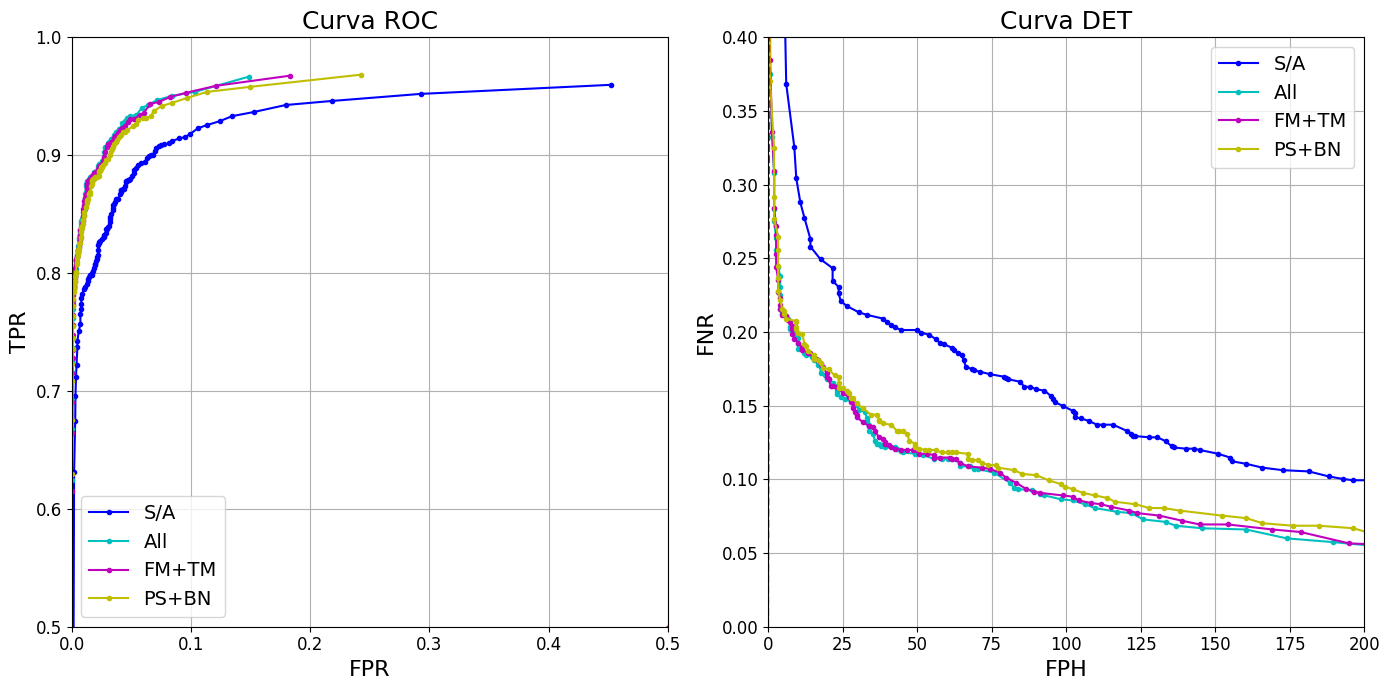

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# List of dataframes
dataframes = [sa, all, fm_tm, ps_bn]

# Calculate HORAS for each dataframe
HORAS_list = [(df.iloc[1, 0] + df.iloc[1, 1] + df.iloc[1, 2] + df.iloc[1, 3]) * 0.96 / 3600 for df in dataframes]

# Names for each dataframe for labeling the plots
labels = ['S/A', 'All', 'FM+TM', 'PS+BN']

# Create subplots
fig, axis = plt.subplots(1, 2, figsize=(14, 7))

# Colors for each dataframe
colors = ['b', 'c', 'm', 'y']

for df, HORAS, label, color in zip(dataframes, HORAS_list, labels, colors):
    df['TPR'] = df['TP'] / (df['TP'] + df['FN'])
    df['FPR'] = df['FP'] / (df['FP'] + df['TN'])
    df['FPH'] = df['FP'] / HORAS
    df['FNR'] = df['FN'] / (df['TP'] + df['FN'])
    
    # Plot the ROC curve
    axis[0].plot(df['FPR'], df['TPR'], marker='.', linestyle='-', color=color, label=label)
    
    # Plot the DET curve
    axis[1].plot(df['FPH'], df['FNR'], marker='.', linestyle='-', color=color, label=label)

# Configure ROC subplot
axis[0].plot([0, 1], [0, 1], 'r--')
axis[0].set_xlim(0, 0.5)
axis[0].set_ylim(0.5, 1)
axis[0].set_xlabel('FPR', fontsize=16)
axis[0].set_ylabel('TPR', fontsize=16)
axis[0].set_title('Curva ROC', fontsize=18)
axis[0].legend(loc='best', fontsize=14)
axis[0].tick_params(axis='both', which='major', labelsize=12)
axis[0].grid()

# Configure DET subplot
axis[1].plot([0, 1], [0, 1], 'r--')
axis[1].set_xlim(0, 200)
axis[1].set_ylim(0, 0.4)
axis[1].set_xlabel('FPH', fontsize=16)
axis[1].set_ylabel('FNR', fontsize=16)
axis[1].set_title('Curva DET', fontsize=18)
axis[1].legend(loc='best', fontsize=14)
axis[1].tick_params(axis='both', which='major', labelsize=12)
axis[1].grid()

plt.tight_layout()
plt.show()


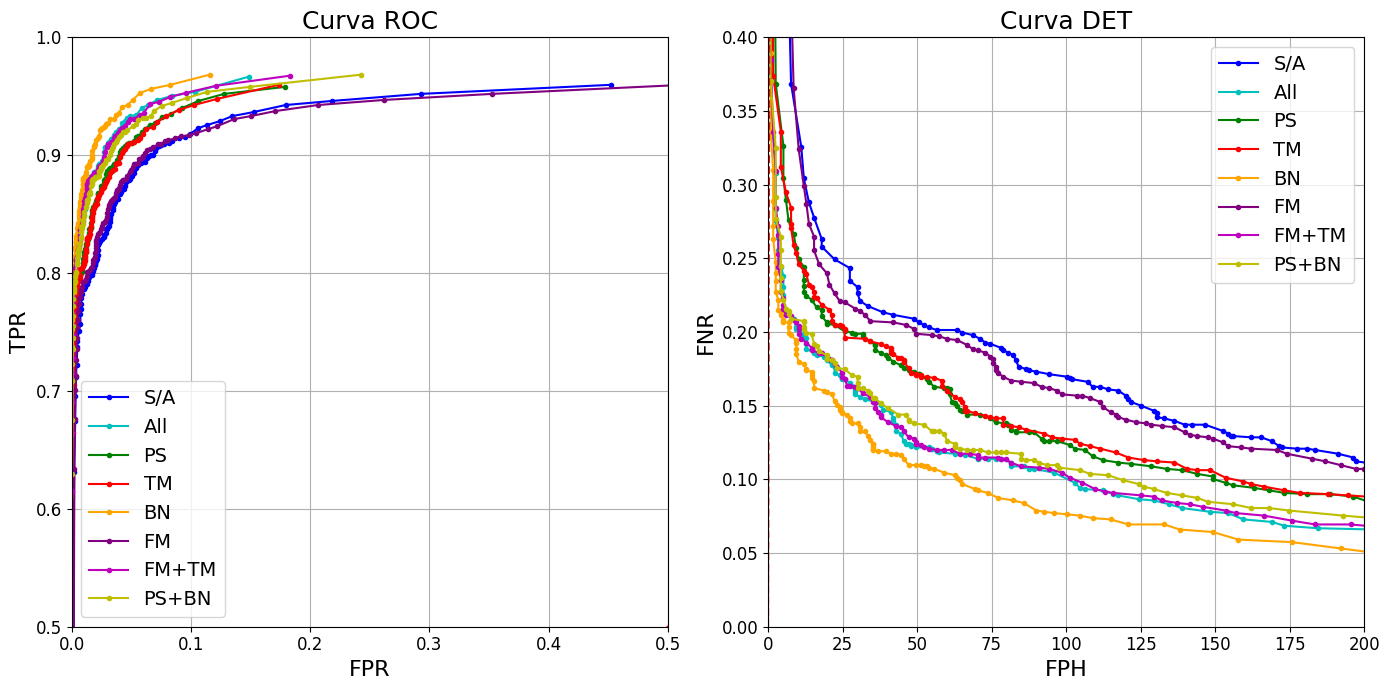

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# List of dataframes
dataframes = [sa, all, ps, tm, bn, fm, fm_tm, ps_bn, ]

# Calculate HORAS for each dataframe
HORAS_list = [(df.iloc[1, 0] + df.iloc[1, 1] + df.iloc[1, 2] + df.iloc[1, 3]) * 0.96 / 3600 for df in dataframes]

# Names for each dataframe for labeling the plots
labels = ['S/A', 'All', 'PS', 'TM', 'BN', 'FM', 'FM+TM', 'PS+BN']

# Create subplots
fig, axis = plt.subplots(1, 2, figsize=(14, 7))

# Colors for each dataframe
colors = ['b', 'c', 'g', 'r', 'orange', 'purple', 'm', 'y']

for df, HORAS, label, color in zip(dataframes, HORAS_list, labels, colors):
    df['TPR'] = df['TP'] / (df['TP'] + df['FN'])
    df['FPR'] = df['FP'] / (df['FP'] + df['TN'])
    df['FPH'] = df['FP'] / HORAS
    df['FNR'] = df['FN'] / (df['TP'] + df['FN'])
    
    # Plot the ROC curve
    axis[0].plot(df['FPR'], df['TPR'], marker='.', linestyle='-', color=color, label=label)
    
    # Plot the DET curve
    axis[1].plot(df['FPH'], df['FNR'], marker='.', linestyle='-', color=color, label=label)

# Configure ROC subplot
axis[0].plot([0, 1], [0, 1], 'r--')
axis[0].set_xlim(0, 0.5)
axis[0].set_ylim(0.5, 1)
axis[0].set_xlabel('FPR', fontsize=16)
axis[0].set_ylabel('TPR', fontsize=16)
axis[0].set_title('Curva ROC', fontsize=18)
axis[0].legend(loc='best', fontsize=14)
axis[0].tick_params(axis='both', which='major', labelsize=12)
axis[0].grid()

# Configure DET subplot
axis[1].plot([0, 1], [0, 1], 'r--')
axis[1].set_xlim(0, 200)
axis[1].set_ylim(0, 0.4)
axis[1].set_xlabel('FPH', fontsize=16)
axis[1].set_ylabel('FNR', fontsize=16)
axis[1].set_title('Curva DET', fontsize=18)
axis[1].legend(loc='best', fontsize=14)
axis[1].tick_params(axis='both', which='major', labelsize=12)
axis[1].grid()

plt.tight_layout()
plt.show()

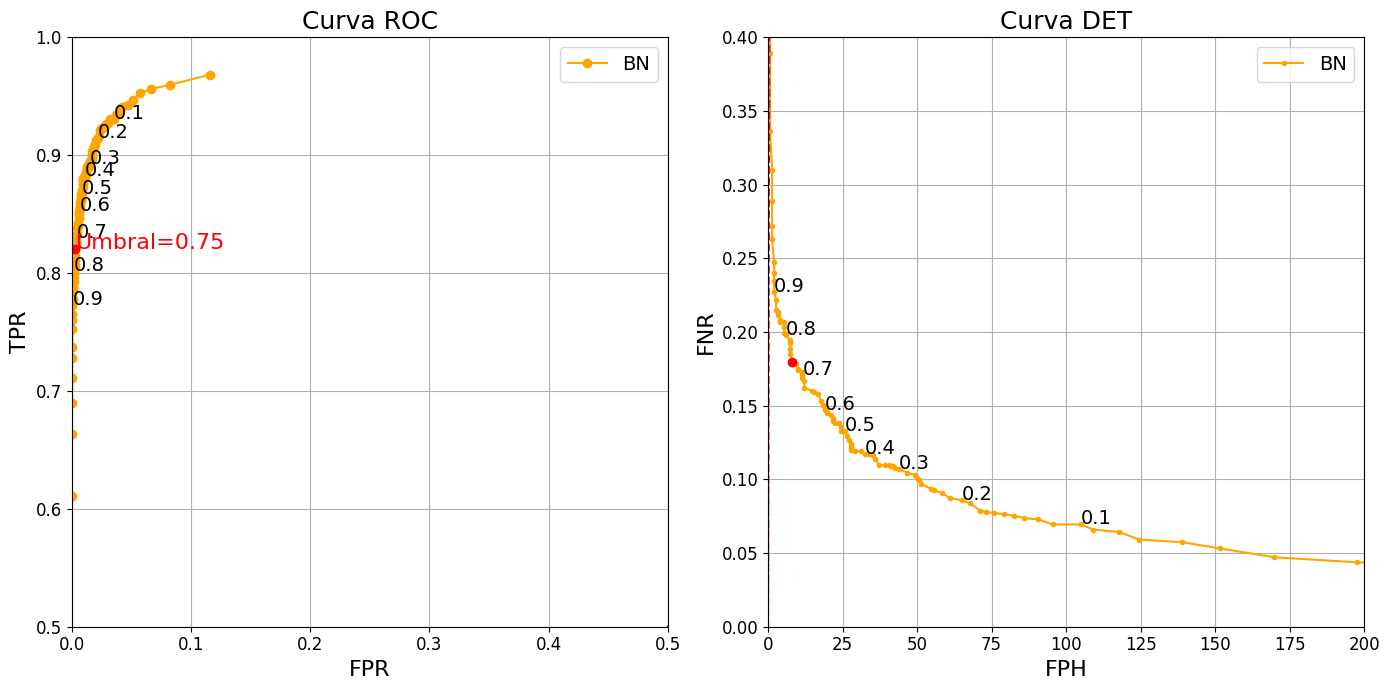

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# List of dataframes
dataframes = [bn]

# Calculate HORAS for each dataframe
HORAS_list = [(df.iloc[1, 0] + df.iloc[1, 1] + df.iloc[1, 2] + df.iloc[1, 3]) * 0.96 / 3600 for df in dataframes]

# Names for each dataframe for labeling the plots
labels = ['BN']

# Create subplots
fig, axis = plt.subplots(1, 2, figsize=(14, 7))

# Colors for each dataframe
colors = ['orange']

# List of points for annotation
points_list = np.linspace(0.01, 1, 100, dtype=np.float64).round(2).tolist()
annotation_points = {0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9}

for df, HORAS, label, color in zip(dataframes, HORAS_list, labels, colors):
    df['TPR'] = df['TP'] / (df['TP'] + df['FN'])
    df['FPR'] = df['FP'] / (df['FP'] + df['TN'])
    df['FPH'] = df['FP'] / HORAS
    df['FNR'] = df['FN'] / (df['TP'] + df['FN'])
    
    # Plot the ROC curve
    axis[0].plot(df['FPR'], df['TPR'], marker='o', linestyle='-', color=color, label=label)
    for i, txt in enumerate(points_list[:len(df)]):
        if txt in annotation_points:
            axis[0].annotate(txt, (df['FPR'].iloc[i], df['TPR'].iloc[i]), fontsize=14)

    # Plot the DET curve
    axis[1].plot(df['FPH'], df['FNR'], marker='.', linestyle='-', color=color, label=label)
    for i, txt in enumerate(points_list[:len(df)]):
        if txt in annotation_points:
            axis[1].annotate(txt, (df['FPH'].iloc[i], df['FNR'].iloc[i]), fontsize=14)

axis[0].plot(df['FPR'].iloc[74], df['TPR'].iloc[74], 'ro')  # Red dot on the point
axis[0].annotate('Umbral=0.75', (df['FPR'].iloc[74], df['TPR'].iloc[74]), fontsize=16, color='red')

axis[1].plot(df['FPH'].iloc[74], df['FNR'].iloc[74], 'ro')  # Red dot on the point
#axis[1].annotate('Umbral=0.88', (df['FPR'].iloc[87], df['TPR'].iloc[87]), fontsize=12, color='red')

# Configure ROC subplot
axis[0].plot([0, 1], [0, 1], 'r--')
axis[0].set_xlim(0, 0.5)
axis[0].set_ylim(0.5, 1)
axis[0].set_xlabel('FPR', fontsize=16)
axis[0].set_ylabel('TPR', fontsize=16)
axis[0].set_title('Curva ROC', fontsize=18)
axis[0].legend(loc='best', fontsize=14)
axis[0].tick_params(axis='both', which='major', labelsize=12)
axis[0].grid()

# Configure DET subplot
axis[1].plot([0, 1], [0, 1], 'r--')
axis[1].set_xlim(0, 200)
axis[1].set_ylim(0, 0.4)
axis[1].set_xlabel('FPH', fontsize=16)
axis[1].set_ylabel('FNR', fontsize=16)
axis[1].set_title('Curva DET', fontsize=18)
axis[1].legend(loc='best', fontsize=14)
axis[1].tick_params(axis='both', which='major', labelsize=12)
axis[1].grid()

plt.tight_layout()
plt.show()


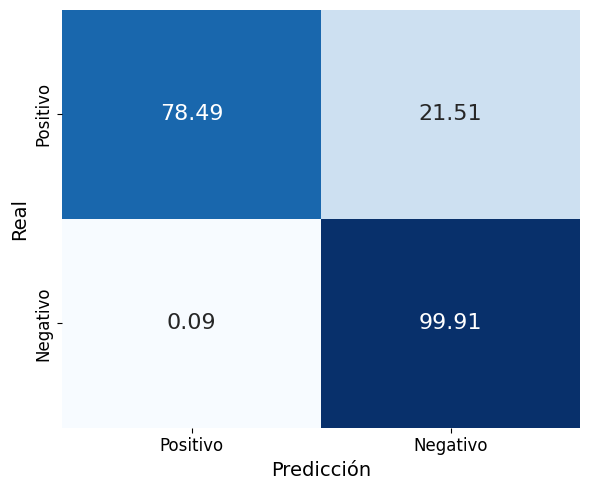

In [133]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the values for one confusion matrix
tp = 916
tn = 4369
fp = 4
fn = 251

# Calculate the total number of actual positives and negatives
total_positives = tp + fn
total_negatives = tn + fp

# Create the confusion matrix with percentages
confusion_matrix = np.array([
    [tp / total_positives * 100, fn / total_positives * 100],
    [fp / total_negatives * 100, tn / total_negatives * 100]
])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, annot_kws={"size": 16})
#ax.set_title("", fontsize=16)
ax.set_xlabel('Predicción', fontsize=14)
ax.set_ylabel('Real', fontsize=14)
ax.set_xticklabels(['Positivo', 'Negativo'], fontsize=12)
ax.set_yticklabels(['Positivo', 'Negativo'], fontsize=12)
plt.tight_layout()
plt.show()


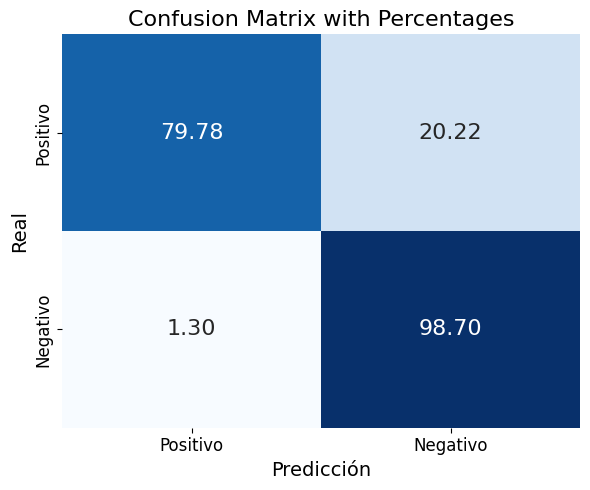

In [96]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the values for one confusion matrix
tp = 931
tn = 4316
fp = 57
fn = 236

# Calculate the total number of actual positives and negatives
total_positives = tp + fn
total_negatives = tn + fp

# Create the confusion matrix with percentages
confusion_matrix = np.array([
    [tp / total_positives * 100, fn / total_positives * 100],
    [fp / total_negatives * 100, tn / total_negatives * 100]
])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, annot_kws={"size": 16})
ax.set_title("Confusion Matrix with Percentages", fontsize=16)
ax.set_xlabel('Predicción', fontsize=14)
ax.set_ylabel('Real', fontsize=14)
ax.set_xticklabels(['Positivo', 'Negativo'], fontsize=12)
ax.set_yticklabels(['Positivo', 'Negativo'], fontsize=12)
plt.tight_layout()
plt.show()

In [122]:
df['FPH']

0     908.986965
1     561.685342
2     426.194832
3     362.737251
4     314.715298
         ...    
95      2.572605
96      2.572605
97      2.572605
98      0.857535
99      0.000000
Name: FPH, Length: 100, dtype: float64

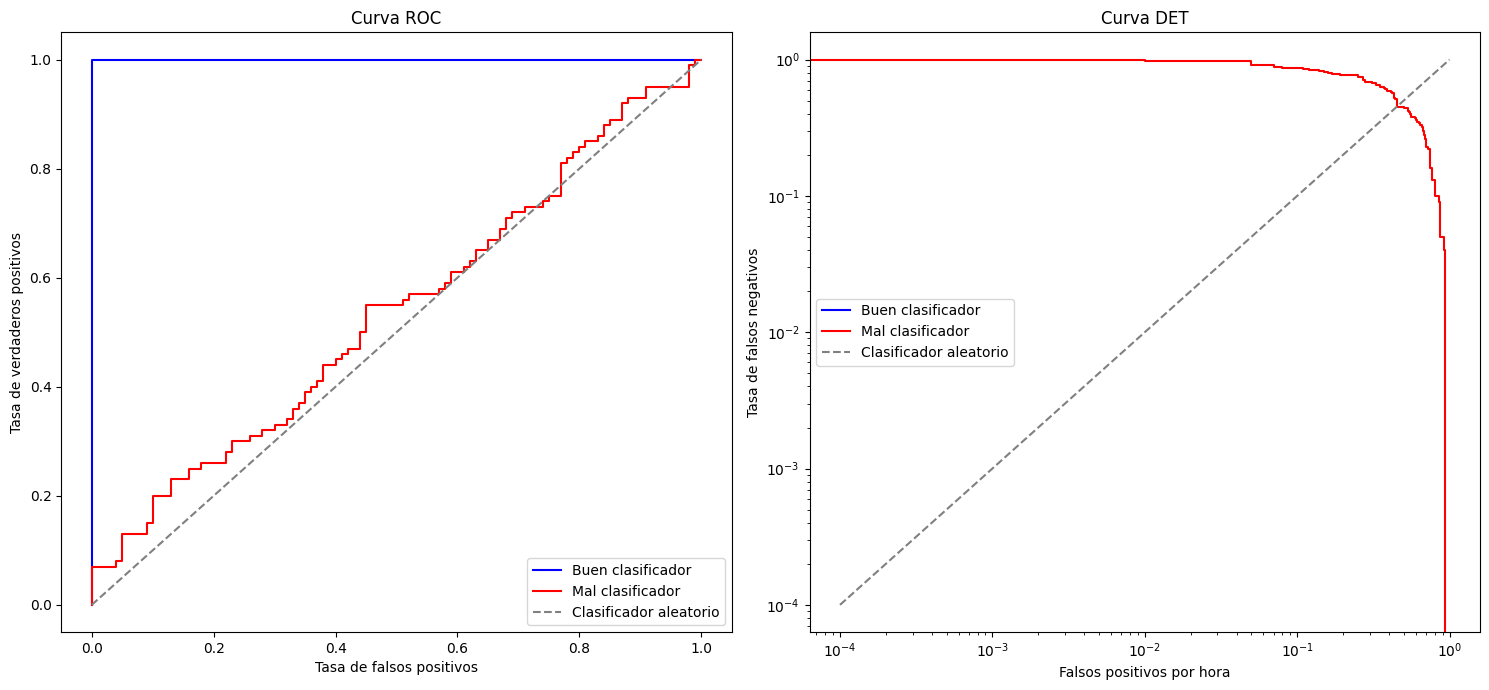

In [1]:
import numpy as np
from sklearn.metrics import roc_curve, det_curve
import matplotlib.pyplot as plt

# Crear datos simulados para un buen clasificador y un mal clasificador
np.random.seed(0)
y_true = np.concatenate([np.ones(100), np.zeros(100)])
# Buen clasificador: probabilidades que separan claramente las clases
y_scores_good = np.concatenate([np.random.uniform(0.7, 1, 100), np.random.uniform(0, 0.3, 100)])
# Mal clasificador: probabilidades mezcladas
y_scores_bad = np.concatenate([np.random.uniform(0.4, 0.6, 100), np.random.uniform(0.4, 0.6, 100)])

# Calcular las curvas ROC para ambos clasificadores
fpr_good, tpr_good, _ = roc_curve(y_true, y_scores_good)
fpr_bad, tpr_bad, _ = roc_curve(y_true, y_scores_bad)

# Calcular las curvas DET para ambos clasificadores
fnr_good, fpr_det_good, _ = det_curve(y_true, y_scores_good)
fnr_bad, fpr_det_bad, _ = det_curve(y_true, y_scores_bad)

# Plotear las curvas ROC y DET
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Curva ROC
axs[0].plot(fpr_good, tpr_good, color='blue', label='Buen clasificador')
axs[0].plot(fpr_bad, tpr_bad, color='red', label='Mal clasificador')
axs[0].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Clasificador aleatorio')
axs[0].set_title('Curva ROC')
axs[0].set_xlabel('Tasa de falsos positivos')
axs[0].set_ylabel('Tasa de verdaderos positivos')
axs[0].legend()

# Curva DET
axs[1].plot(fpr_det_good, fnr_good, color='blue', label='Buen clasificador')
axs[1].plot(fpr_det_bad, fnr_bad, color='red', label='Mal clasificador')
axs[1].plot([1e-4, 1], [1e-4, 1], color='gray', linestyle='--', label='Clasificador aleatorio')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Curva DET')
axs[1].set_xlabel('Falsos positivos por hora')
axs[1].set_ylabel('Tasa de falsos negativos')
axs[1].legend()

plt.tight_layout()
plt.show()
